# Derive models of drone

Do all imports.

In [219]:
import sympy as sym
import numpy as np

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Dynamic model

Define physical parameters.

In [220]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion:

In [221]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Here is the function $f$:

In [222]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

## Sensor model

Define the sensor model.

In [223]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi, \theta, \phi)$$

Here is the function $g$:

In [224]:
g

Matrix([
[p_x + 7*sin(phi)*sin(theta)*cos(psi)/40 - 7*sin(psi)*cos(phi)/40],
[p_y + 7*sin(phi)*sin(psi)*sin(theta)/40 + 7*cos(phi)*cos(psi)/40],
[                                  p_z + 7*sin(phi)*cos(theta)/40],
[p_x - 7*sin(phi)*sin(theta)*cos(psi)/40 + 7*sin(psi)*cos(phi)/40],
[p_y - 7*sin(phi)*sin(psi)*sin(theta)/40 - 7*cos(phi)*cos(psi)/40],
[                                  p_z - 7*sin(phi)*cos(theta)/40]])

## Find A and B

In [225]:
from scipy.linalg import solve_continuous_are
import numpy.linalg as la

m = (p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z)
n = (tau_x,tau_y,tau_z,f_z)
mn = (p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z)

An = sym.lambdify(mn, f.jacobian(m))
Bn = sym.lambdify(mn, f.jacobian(n))

A = An(0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,(0.5 * 9.81))
B = Bn(0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,(0.5 * 9.81))
print("Matrix A:")
print(A.tolist())
print("Matrix B:")
print(B.tolist())

Matrix A:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Matrix B:
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0,

In [226]:
def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

In [227]:
Q = np.diag((1,1,100000,1,1,1,1,1,1,1,1,1)) * 100
R = np.diag((1,1,1,1)) * 1

W = B
for i in range(1, A.shape[0]):
    W = np.block([W, la.matrix_power(A, i) @ B])

if W.shape[0] == la.matrix_rank(W):
    print("System is controllable.")
    K = lqr(A,B,Q,R)
    print("Matrix K:")
    print(K.tolist())
else:
    print("System is not controllable.")

System is controllable.
Matrix K:
[[-1.1630948302793195e-12, -9.999999999999261, -1.8002177073317408e-11, 6.05552954911236e-14, -4.204054660132301e-12, 54.32721336689191, -1.3483914544259895e-12, -14.517535768328141, 2.4717581015501244e-14, 10.012487462238871, 1.1013387329099584e-16, -1.4547259482124014e-14], [10.000000000001684, -6.248541815509776e-13, -1.5415743684595426e-12, -3.0230903452143434e-13, 54.327213366904395, 2.285790831980737e-13, 14.517535768330868, -2.9273743672596625e-13, 5.000722781845537e-15, 1.1013387329099584e-16, 10.012487462238763, -2.5573293970452534e-15], [-6.786050177053465e-13, -3.869893978711842e-14, -6.0965322861079655e-12, 9.99999999999995, -3.3559999385161726e-12, 7.122495973839099e-14, -8.778472370759233e-13, -2.5421323327004266e-14, -6.500189934644762e-14, -8.364674202221307e-15, -1.4704644033010208e-15, 10.003999200319848], [6.435861623661358e-14, -3.3242279921975054e-14, 3162.2776601683986, 1.6436635931069e-14, 1.5276489544326095e-13, -1.0642288597827

In [228]:
o_e = g.subs({p_x: 0, p_y: 0, p_z: 1, psi: 0, theta: 0, phi: 0})
o_e = np.array(o_e.T.evalf())
o_e = np.array(o_e[0])
print(o_e)

[0 0.175000000000000 1.00000000000000 0 -0.175000000000000
 1.00000000000000]


In [229]:
m = (p_x,p_y,p_z,psi,theta,phi)
n = ()
mn = (p_x,p_y,p_z,psi,theta,phi)

# No D because there are no inputs in the sensor model
Cn = sym.lambdify(mn, g.jacobian(m))
#Dn = sym.lambdify(mn, f.jacobian(n))

C = Cn(0,0,1,0,0,0)
C = np.hstack((C, np.zeros((C.shape[0], 6))))
#D = Dn(0,0,0,0,0,0)
print("Matrix C:")
print(C.tolist())
display(sym.Matrix(C))
# print("Matrix D:")
# print(D.tolist())

Matrix C:
[[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


Matrix([
[1.0, 0.0, 0.0, -0.175, 0.0,    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0,    0.0, 0.0,    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0,    0.0, 0.0,  0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[1.0, 0.0, 0.0,  0.175, 0.0,    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0,    0.0, 0.0,    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0,    0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [230]:

# Define weight matrices for LQR
Q0 = np.eye(C.shape[0]) * 10000
R0 = np.eye(A.shape[0]) * 1

O = C
for i in range(1, A.shape[0]):
    O = np.vstack([O, C @ la.matrix_power(A, i)])

if A.shape[0] == la.matrix_rank(O):
    print("System is observable.")
    L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T
    print("Matrix L:")
    print(L.tolist())
else:
    print("System is not observable, the rank is", la.matrix_rank(O))

System is observable.
Matrix L:
[[73.42340077712699, 9.398587125256288e-12, 9.70709140673279e-12, 73.42340077712869, 9.398587125256288e-12, 9.576597445933534e-12], [9.378317892706496e-12, 71.24629727167165, -0.16448648569815577, 9.41885635780608e-12, 71.24629727167165, 0.1644864857099675], [9.791603549730799e-12, 5.905853609983948e-12, 71.20892274229757, 9.492085302935526e-12, 5.905853609983948e-12, 71.20892274229635], [-73.51231881678181, 1.1582418599881272e-13, -8.183490513861247e-13, 73.51231881679159, 1.1582418599881272e-13, -8.931837874440133e-13], [103.1339467947346, 1.141523376272989e-11, 1.3518324024328321e-11, 103.13394679473642, 1.141523376272989e-11, 1.330481674256672e-11], [3.354225199689309e-13, -0.9399227754517807, 73.50626609241476, 4.1025725602681955e-13, -0.9399227754517807, -73.50626609240774], [390.99578167915143, 4.281935481817725e-11, 5.190107451366692e-11, 390.99578167916053, 4.281935481817725e-11, 5.111869048998993e-11], [7.963284514018498e-12, 76.06193072716201,

# Setup and Run the Simulation

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

seed = secrets.randbits(32)
seed = 3608613279
print(seed)

simulator = ae353_drone.Simulator(seed=seed)

simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'start',          # type of view (start, top, right, left, or back)
)
simulator.clear_drones()

3608613279
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


In [232]:
class Controller:
    def __init__(self, dt = 0.04):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.o_e = o_e
        self.dt = dt
        self.xhat = np.zeros(12)

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):

        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0])

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on left rotor (meters),
                measured y position of marker on left rotor (meters),
                measured z position of marker on left rotor (meters),
                measured x position of marker on right rotor (meters),
                measured y position of marker on right rotor (meters),
                measured z position of marker on right rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all other active drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """
        u = -self.K @ self.xhat
        
        y = pos_markers - np.array([0,.175,1,0,-.175,1])

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )

        tau_x, tau_y, tau_z, f_z = u

        return tau_x, tau_y, tau_z, f_z

In [233]:
simulator.add_drone(Controller, 'template', 'template.png')
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 1,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.,
            'p_y_meas': 0.,
            'p_z_meas': 1,
            'yaw_meas': 0.,
        },
    },
)
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
    error_on_inactive=False, # <-- allow inactivity
)
simulator.run(
    max_time=5.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)


drone template is out of bounds (turning it off)

Simulated 83 time steps in 3.3216 seconds (24.9879 time steps per second)


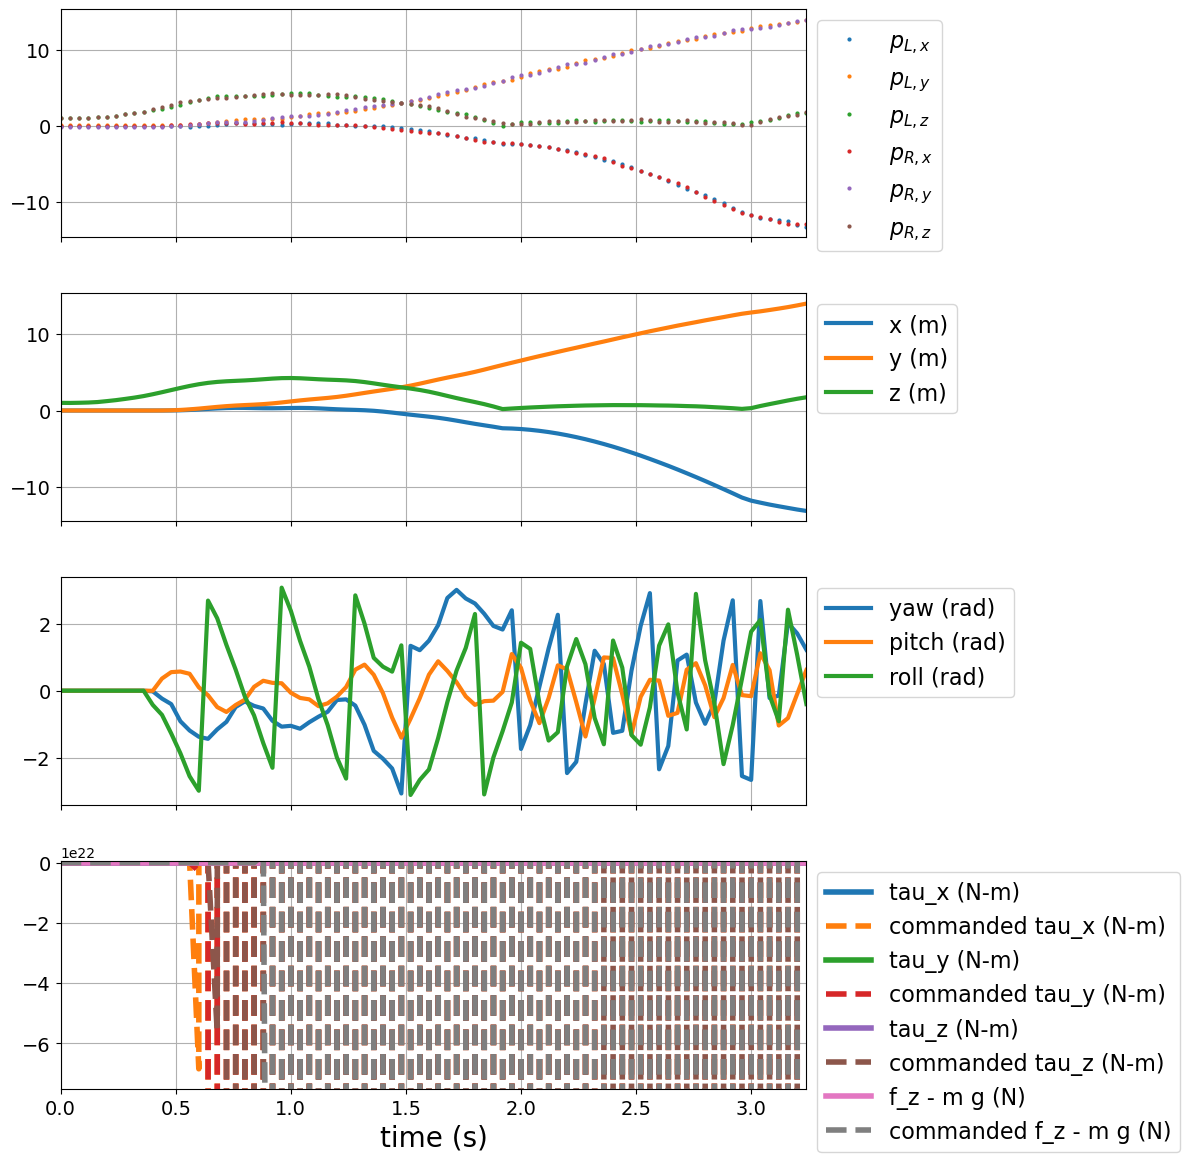

In [234]:
data = simulator.get_data('template')
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

import numpy as np

# Get the time array
t = np.array(data['t'])

# Compute 80% index directly
cutoff_idx = int(0.2 * len(t))

# Slice relevant data
tau_x      = np.array(data['tau_x'][:cutoff_idx])
tau_x_cmd  = np.array(data['tau_x_cmd'][:cutoff_idx])
tau_y      = np.array(data['tau_y'][:cutoff_idx])
tau_y_cmd  = np.array(data['tau_y_cmd'][:cutoff_idx])
tau_z      = np.array(data['tau_z'][:cutoff_idx])
tau_z_cmd  = np.array(data['tau_z_cmd'][:cutoff_idx])
f_z        = np.array(data['f_z'][:cutoff_idx]) - 0.5 * 9.81
f_z_cmd    = np.array(data['f_z_cmd'][:cutoff_idx]) - 0.5 * 9.81

# Combine all into one array for convenience
all_vals = np.concatenate([
    tau_x, tau_x_cmd,
    tau_y, tau_y_cmd,
    tau_z, tau_z_cmd,
    f_z, f_z_cmd
])

# Get min and max with 10% buffer
ymin = 1.1 * np.min(all_vals)
ymax = 1.1 * np.max(all_vals)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], np.array(data['f_z']) - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4)
ax_act.plot(data['t'], np.array(data['f_z_cmd']) - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4)
ax_act.set_ylim(ymin, ymax)  # Set both y-limits
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)



# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()